### DEIT-III Pre-trained Artifacts

In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt



In [2]:
from models_v2 import *

In [3]:
tiny = deit_tiny_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)
small = deit_small_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)
# base = deit_base_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True) 
# large = deit_large_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)

In [4]:
def show_artifacts(test_model, test_image, log_scale = False, token = 0):
    """
    Generate the Attention maps and the norm values for the DEIT-III model

    test_model: DEIT-III model to be tested,
    test_image:  Image of the correct size for the corresponding model, and batch dimension is accounted for

    """

    test_model(test_image)

    ## Norm of feature values after MLP
    output = test_model.block_output['block11']
    output = output.squeeze(0)
    output = output[1:]
    #output.shape
    # copmute norm of all output elements
    output_norms = output.norm(dim=-1)
    #output_norms.shape
    
    plt.imshow(output_norms.reshape(24, 24).detach().numpy())
    plt.axis('off')  # Turn off axis labels
    plt.colorbar(label='Norm Values')  # Add a colorbar as a legend
    plt.show()

    plt.hist(output_norms.detach().numpy(), bins=50)
    plt.xlabel('Norm Values')
    plt.ylabel('Frequency')
    plt.show()

    ## Attention maps for the last Attention Head

    
    attn_map_mean = test_model.blocks[len(test_model.blocks)-1].attn.attn_map.squeeze(0).mean(dim=0)
    attn_map_mean = attn_map_mean[token][1:]
    if log_scale:
        attn_map_mean = torch.log(attn_map_mean + 1e-6)
    #attn_map_mean.shape

    plt.imshow(attn_map_mean.reshape(24, 24).detach().numpy())
    plt.axis('off') 
    plt.colorbar(label='CLS attention map')  
    plt.show()



    ## All attention maps
    num_images = len(test_model.blocks)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_images):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        attn_map = attn_map[token][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Block {i+1}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    


In [5]:
def show_all_tokens(test_model):
    # # Attention maps, last layer, all tokens
    num_tokens = 24 * 24
    num_cols = 6
    num_rows = (num_tokens + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_tokens):
        attn_map = test_model.blocks[len(test_model.blocks)-1].attn.attn_map.squeeze(0).mean(dim=0)
        attn_map = attn_map[i][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Token {i+1}')


In [6]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Assume `image_tensor` is a tensor of shape (3, H, W), e.g., (3, 32, 32)
def plot_image(image_tensor):
    # Undo normalization if needed (optional step)

    # Convert tensor to NumPy format
    image_np = image_tensor.permute(1, 2, 0).numpy()  # Rearrange to (H, W, C)

    # Clip values to the valid range [0, 1]
    image_np = image_np.clip(0, 1)

    # Plot the image
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example: Plot a single image from CIFAR-100
import torchvision



### Nice stuff

In [7]:
chosen_one = small
chosen_one

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,

In [8]:
image = 'racket.JPEG'

In [9]:
from PIL import Image
import numpy as np
import torch

def get_image(image):
    # Open the image
    img = Image.open('./images/' + image).convert('RGB')

    # Resize the image to 384x384
    img = img.resize((384, 384))

    # Convert the image to a NumPy array and transpose the dimensions
    img = np.array(img).transpose(2, 0, 1)

    # Convert the NumPy array to a PyTorch tensor and normalize the values
    img = torch.tensor(img).float() / 255.0

    # Add a batch dimension
    img = img.unsqueeze(0)

    return img

img = get_image(image)



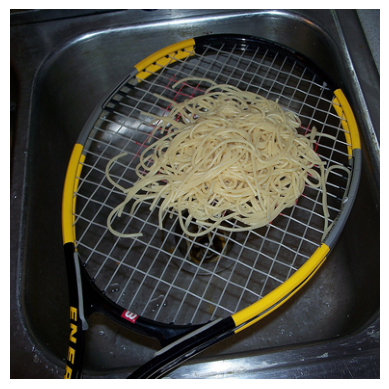

In [10]:
plot_image(img.squeeze(0))

In [11]:
chosen_one(img).shape

torch.Size([1, 1000])

### Alisia stuff (bad)

In [12]:
combined_attention = chosen_one.blocks[11].attn.attn_map.squeeze(0).mean(dim=0)[1:, 1:].detach().numpy()
combined_attention.shape

(576, 576)

In [13]:
chosen_one.block_output['block11'].shape

torch.Size([1, 577, 384])

In [14]:
local_feature_norms = chosen_one.block_output['block11'].squeeze(0).norm(dim=-1)[1:].reshape(24, 24).detach().numpy()
local_feature_norms.shape


(24, 24)

Mean norm for high-attention patches: 827.8550415039062


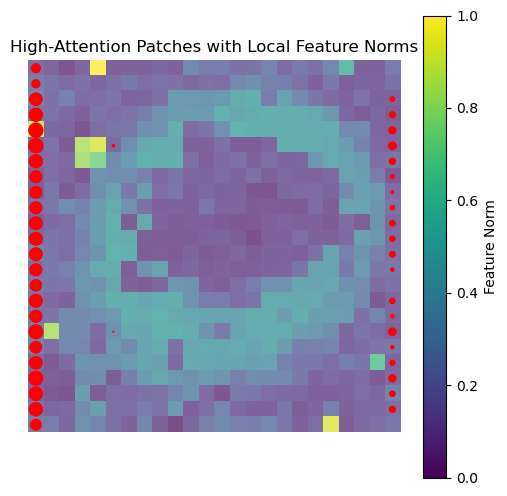

In [15]:
import numpy as np

high_attention_threshold = np.percentile(combined_attention, 99.9)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 24
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms, cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.show()


### Back to the good part

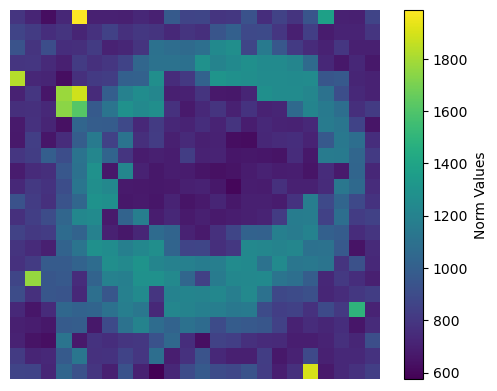

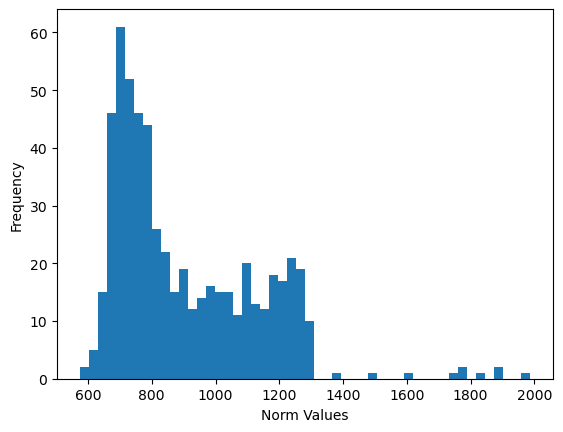

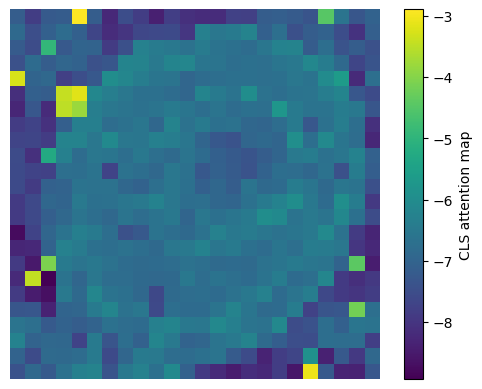

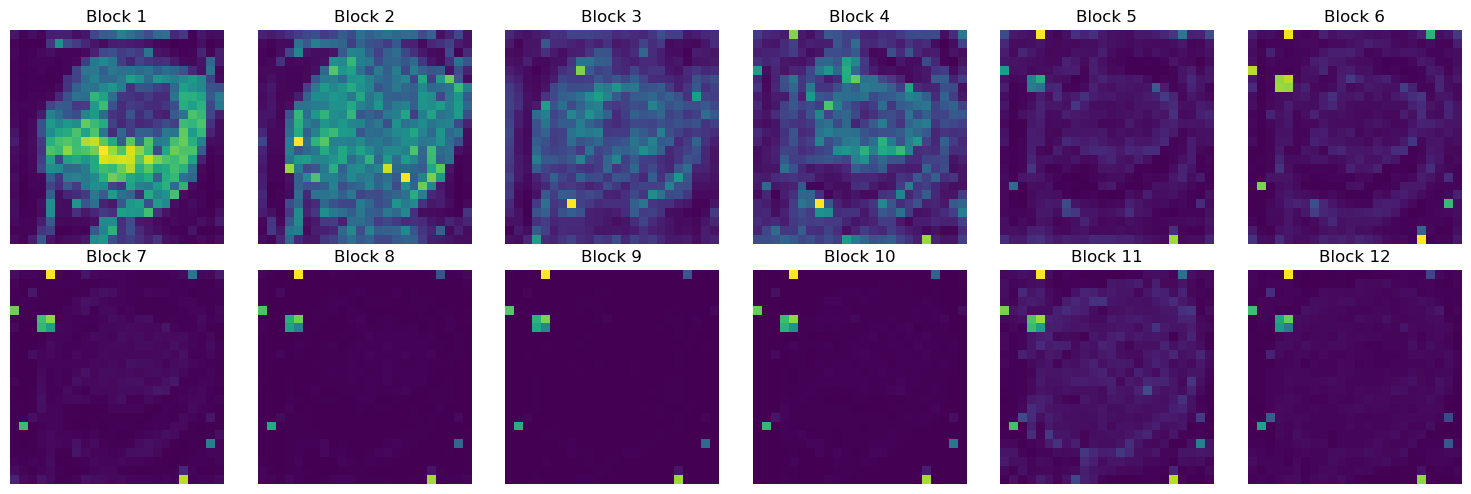

In [16]:
show_artifacts(test_model=chosen_one, test_image=img, log_scale=True, token = 0)

In [17]:
def top_norm_tokens(test_model, block = 11):
    output = test_model.block_output['block'+str(block)]
    #output = output.squeeze(0)
    output = output[:, 1:]
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True, dim=1)
    return top_tokens


In [18]:
def top_attn_tokens(test_model, block = 11):
    attn_map_mean = test_model.blocks[block].attn.attn_map.mean(dim=1)
    top_tokens = torch.argsort(attn_map_mean[:, 0, 1:], descending=True)
    return top_tokens

In [19]:
def find_artifacts(test_model, block = 11):
    intersection = []
    top_norm = top_norm_tokens(test_model, block)[:, :10]
    top_attn = top_attn_tokens(test_model, block)[:, :10]

    for i in range(top_norm.shape[0]):
        intersection.append(np.intersect1d(top_attn[i].cpu(), top_norm[i].cpu()))
    return intersection

In [20]:
intersection = find_artifacts(chosen_one, block = 11)
intersection

[array([  4,  96, 123, 124, 147, 148, 409, 478, 571])]

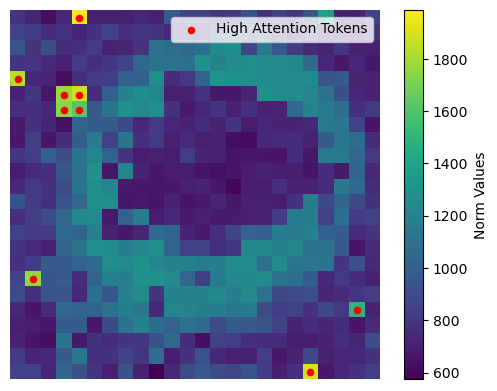

In [21]:
## Norm of feature values after MLP
output = chosen_one.block_output['block11']
output = output.squeeze(0)
output = output[1:]
# compute norm of all output elements
output_norms = output.norm(dim=-1)

plt.imshow(output_norms.reshape(24, 24).detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.colorbar(label='Norm Values')  # Add a colorbar as a legend

# Place red dots at the pixels present in the "intersection" vector
intersection_indices = np.unravel_index(intersection[0], (24, 24))
plt.scatter(intersection_indices[1], intersection_indices[0], color='red', s=20, label='High Attention Tokens')  # Adjusted dot size

# Add a legend
plt.legend(loc='upper right')

plt.show()

### check selected tokens

In [22]:
def show_progression(test_model, token = 'cls'):
    ## All attention maps
    num_images = len(test_model.blocks)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_images):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        if token == 'cls':
            attn_map = attn_map[0][1:]
        else:
            attn_map = attn_map[token + 1][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Block {i+1}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

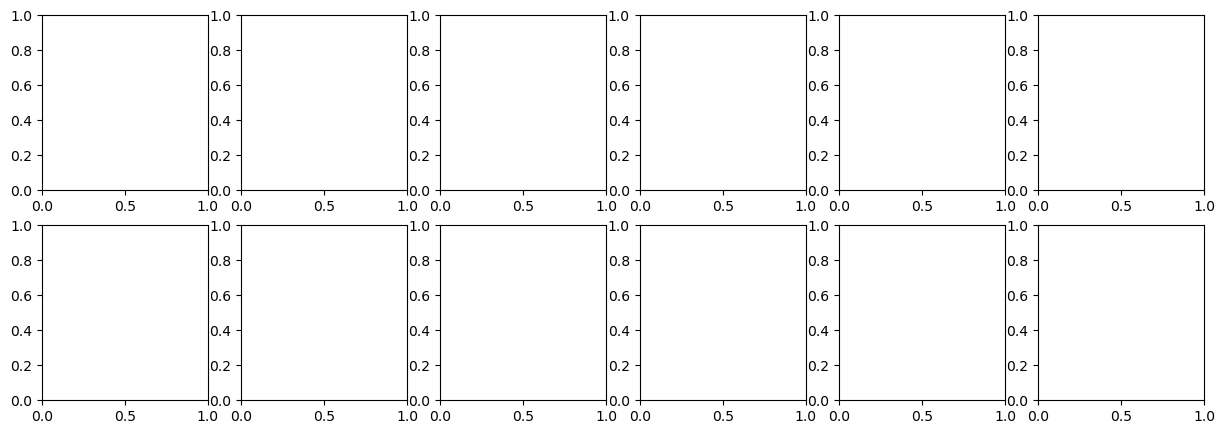

In [23]:
for x in intersection:
    show_progression(chosen_one, token = x)

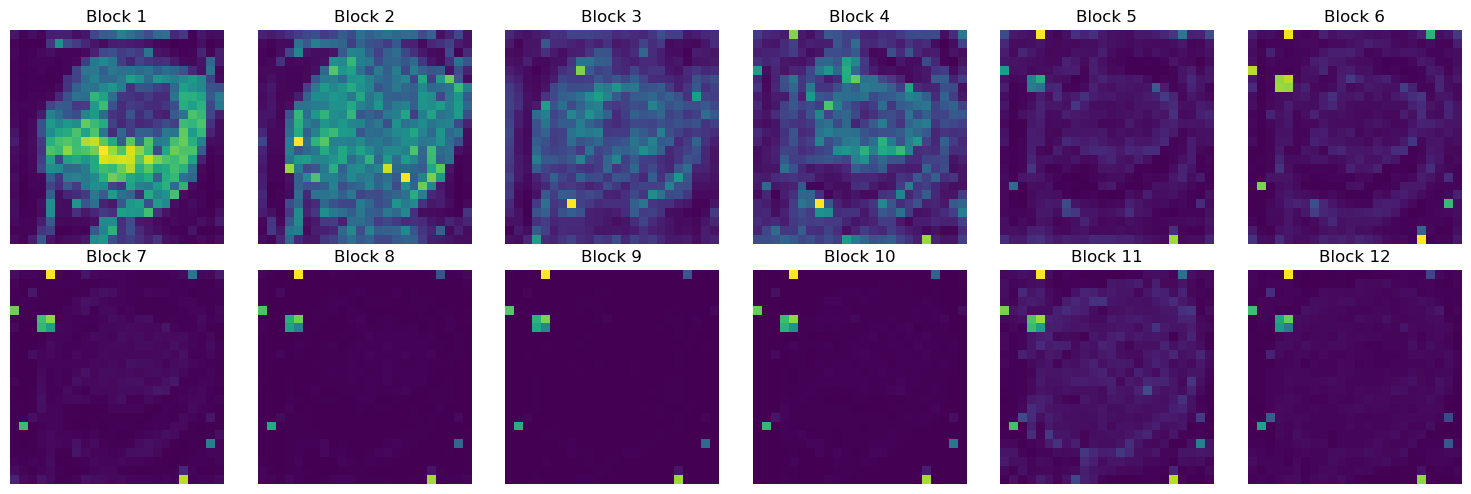

In [80]:
show_progression(chosen_one, token = 'cls')

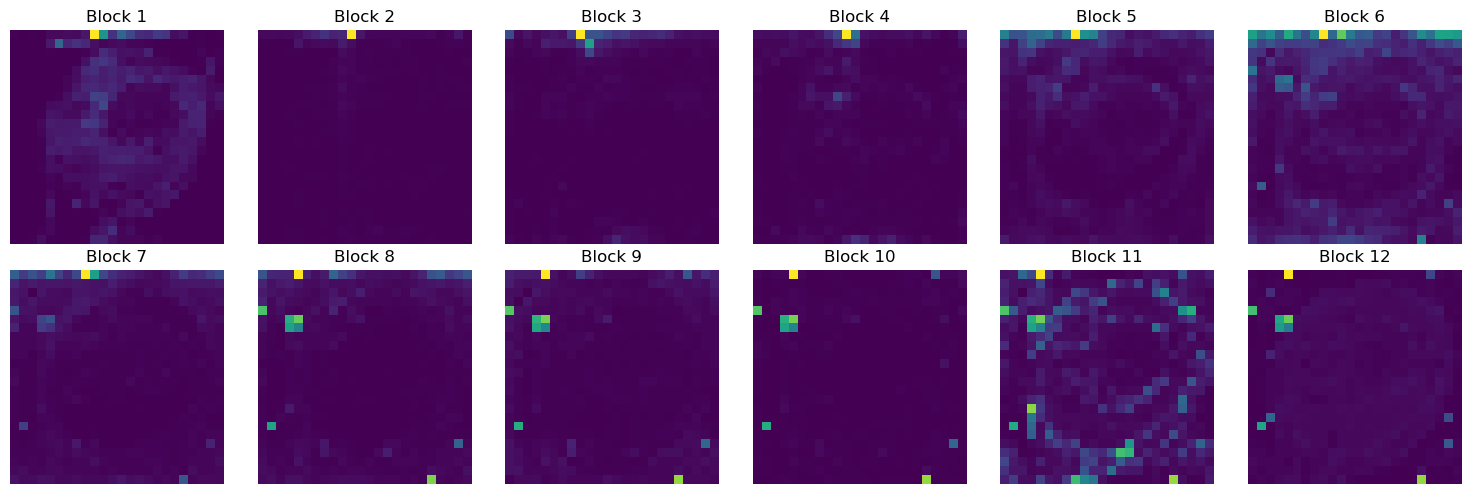

In [81]:
show_progression(chosen_one, token = 9)

### training with cifar

In [26]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1500
test_subset_size = 400
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading DINOv2 model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_one
model.to(device)
model.eval()
print("DINOv2 model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1500 training images, 400 testing images...
Subsets and DataLoaders ready.
Loading DINOv2 model...
DINOv2 model loaded and ready.


In [27]:
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        model(images)
    a = model.block_output['final']
    break

In [28]:
a.shape

torch.Size([16, 577, 384])

In [29]:
from sklearn.model_selection import train_test_split

# Extract Patch Embeddings and Norms

high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        model(images)
        #features = model.block_output['final']
        features = model.block_output['block11']
        
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]

            single_norms_tensor = torch.tensor(single_norms)
            top_tokens = torch.argsort(single_norms_tensor, descending=True)[:10].numpy()
            high_indices = np.where(single_norms > single_norms[top_tokens[-1]])[0]
            normal_indices = np.where(single_norms <= single_norms[top_tokens[-1]])[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [30]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.8467
Normal Token Accuracy: 0.7867


### cosine similarity

In [27]:
embedding = chosen_one.patch_embed(img).squeeze(0)
top_norm = top_norm_tokens(chosen_one)[:10]

In [28]:
all_tokens = dict()
for x in range(24*24):
    emb = embedding[x].detach()#.numpy()
    right = embedding[(x+1) % (24*24)]
    left = embedding[x-1]
    up = embedding[x-24]
    down = embedding[(x+24) % (24*24)]

    cos_sim = torch.nn.CosineSimilarity(dim=0)
    mean_sim = (cos_sim(emb, right) + cos_sim(emb, left) + cos_sim(emb, up) + cos_sim(emb, down))/4

    all_tokens[x] = mean_sim.detach().numpy()

In [29]:

top_norm_keys = set(top_norm.cpu().numpy())
top_norm_similarities = [all_tokens[key] for key in top_norm_keys]

not_top_norm_keys = set(all_tokens.keys()) - top_norm_keys
not_top_norm_similarities = [all_tokens[key] for key in not_top_norm_keys]


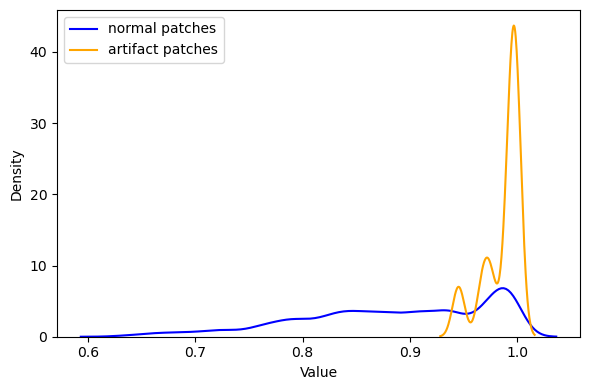

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_norm_similarities = [float(similarity) for similarity in top_norm_similarities]
not_top_norm_similarities = [float(similarity) for similarity in not_top_norm_similarities]

# Plot density
plt.figure(figsize=(6, 4))
sns.kdeplot(not_top_norm_similarities, label='normal patches', color='blue', bw_adjust=0.5)
sns.kdeplot(top_norm_similarities, label='artifact patches', color='orange', bw_adjust=0.5)

# Add labels and legend
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


### training position

In [43]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1000
test_subset_size = 10
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading model...")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_one
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1000 training images, 10 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


In [44]:
device = torch.device('mps')

In [46]:
# put all elements of the train loader in a single ndarray
print("Extracting patch embeddings...")
patch_embeddings = dict()
patch_embeddings = dict()
artifact_indices = dict()
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        chosen_one(images)
    for block in range(12):
        if block not in patch_embeddings:
            patch_embeddings[block] = []
        patch_embeddings[block].append(chosen_one.block_output[f'block{block}'][:,1:,:].cpu().numpy())
        artifacts = find_artifacts(chosen_one, block = block)

        for i in range(images.size(0)):
            if block not in artifact_indices:
                artifact_indices[block] = []
            artifact_indices[block].append(artifacts[i])
            

            
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

for block in range(12):
    patch_embeddings[block] = np.concatenate(patch_embeddings[block], axis=0)

print("Patch embeddings extracted.")


Extracting patch embeddings...
Processed batch 1/63
Processed batch 2/63
Processed batch 3/63
Processed batch 4/63
Processed batch 5/63
Processed batch 6/63
Processed batch 7/63
Processed batch 8/63
Processed batch 9/63
Processed batch 10/63
Processed batch 11/63
Processed batch 12/63
Processed batch 13/63
Processed batch 14/63
Processed batch 15/63
Processed batch 16/63
Processed batch 17/63
Processed batch 18/63
Processed batch 19/63
Processed batch 20/63
Processed batch 21/63
Processed batch 22/63
Processed batch 23/63
Processed batch 24/63
Processed batch 25/63
Processed batch 26/63
Processed batch 27/63
Processed batch 28/63
Processed batch 29/63
Processed batch 30/63
Processed batch 31/63
Processed batch 32/63
Processed batch 33/63
Processed batch 34/63
Processed batch 35/63
Processed batch 36/63
Processed batch 37/63
Processed batch 38/63
Processed batch 39/63
Processed batch 40/63
Processed batch 41/63
Processed batch 42/63
Processed batch 43/63
Processed batch 44/63
Processed 

In [52]:
len(artifact_indices[0])

1000

In [27]:
y = np.array(range(576))
y = np.tile(y, 1000)
y.shape

(576000,)

In [31]:
len(artifact_indices[0])

1000

In [50]:
patch_embeddings[0].shape

(1000, 576, 384)

In [48]:
X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])

In [49]:
X.shape

(576000, 384)

In [53]:
indices = np.random.choice(X.shape[0], 10000, replace=False)

In [55]:
indices

array([484528,  18000, 299740, ..., 472506, 341372, 440437])

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

for block in range(12):
    print(f"Training Linear Regression for block {block}...")
    X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])


    indices = np.random.choice(X.shape[0], 10000, replace=False)
    X_test = X[indices]
    y_test = y[indices]
    X_train = X[[index for index in range(X.shape[0]) if index not in indices]]
    y_train = y[[index for index in range(y.shape[0]) if index not in indices]]

    X_test_artifact = []
    y_test_artifact = []

    for index, x in enumerate(X_test):
        image_number = indices[index] // 576
        artifact_tokens = artifact_indices[block][image_number]
        if indices[index] % 576 in artifact_tokens:
            X_test_artifact.append(x)
            y_test_artifact.append(y_test[index])
        
    X_test_artifact = np.array(X_test_artifact)
    y_test_artifact = np.array(y_test_artifact)
    X_test_no_artifact = X_test[[index for index in range(X_test.shape[0]) if index not in indices]]
    y_test_no_artifact = y_test[[index for index in range(y_test.shape[0]) if index not in indices]]


    reg = LinearRegression().fit(X_train, y_train)

    y_pred_full = reg.predict(X_test)
    y_pred_artifact = reg.predict(X_test_artifact)
    y_pred_no_artifact = reg.predict(X_test_no_artifact)

    accuracy_full = np.mean(np.round(y_pred_full) == y_test)
    accuracy_artifact = np.mean(np.round(y_pred_artifact) == y_test_artifact)
    accuracy_no_artifact = np.mean(np.round(y_pred_no_artifact) == y_test_no_artifact)
    print(f"Block {block} Full Accuracy: {accuracy_full:.4f}, Artifact Accuracy: {accuracy_artifact:.4f}, No Artifact Accuracy: {accuracy_no_artifact:.4f}")



Training Linear Regression for block 0...
Block 0 Full Accuracy: 0.0755, Artifact Accuracy: 0.0370, No Artifact Accuracy: 0.0748
Training Linear Regression for block 1...
Block 1 Full Accuracy: 0.0765, Artifact Accuracy: 0.0600, No Artifact Accuracy: 0.0766
Training Linear Regression for block 2...
Block 2 Full Accuracy: 0.0530, Artifact Accuracy: 0.3333, No Artifact Accuracy: 0.0528
Training Linear Regression for block 3...
Block 3 Full Accuracy: 0.0349, Artifact Accuracy: 0.0106, No Artifact Accuracy: 0.0349
Training Linear Regression for block 4...
Block 4 Full Accuracy: 0.0151, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0153
Training Linear Regression for block 5...
Block 5 Full Accuracy: 0.0062, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0063
Training Linear Regression for block 6...
Block 6 Full Accuracy: 0.0025, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0023
Training Linear Regression for block 7...
Block 7 Full Accuracy: 0.0015, Artifact Accuracy: 0.000

In [38]:
X.shape

(576000, 384)

In [39]:
X_test.shape

(10000, 384)

In [40]:
X_train.shape

(566000, 384)

### norms across layers

In [203]:
chosen_one = small

In [223]:
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_subset_size = 100

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]

train_subset = Subset(train_dataset, train_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

print("Subsets and DataLoaders ready.")

print("Loading model...")
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Creating subsets: 100 training images, 10 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


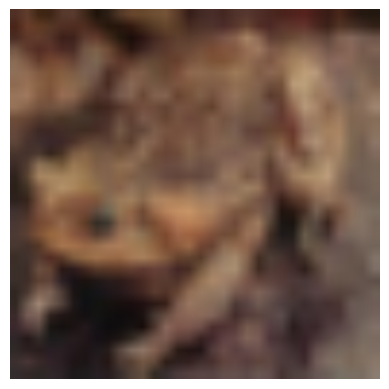

In [230]:
# either run this
for images, targets in train_loader:
    image = images[0]
    break

chosen_one(image.unsqueeze(0))
plot_image(image)

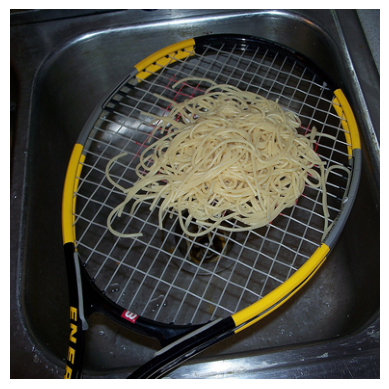

In [ ]:
# or this
chosen_one = chosen_one.to('cpu')
chosen_one(img)
plot_image(img.squeeze(0))

In [228]:
layer_norms = []
for x in range(12):
    layer_norms.append(torch.log(chosen_one.block_output['block'+ str(x)].squeeze()[1:,:].norm(dim = -1) + 1e-6).detach().numpy())
    #layer_norms.append(chosen_one.block_output['block'+ str(x)].squeeze()[1:,:].norm(dim = -1).detach().numpy())


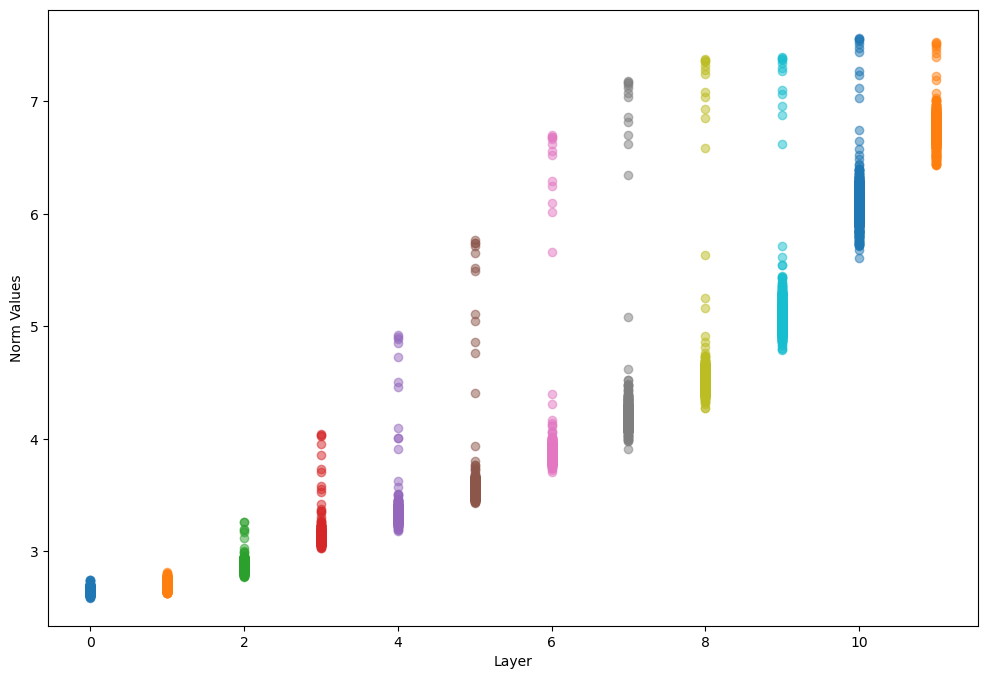

In [229]:
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
for i, norms in enumerate(layer_norms):
    plt.scatter([i] * len(norms), norms, alpha=0.5)
plt.xlabel('Layer')
plt.ylabel('Norm Values')
plt.show()
